# Visualizing Preprocessing Process

## Import

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3
import matplotlib.pyplot as plt
import json
import pydicom as pdc
import numpy as np
import pathlib
import sys
import tensorflow as tf
import h5py

from pprint import pprint
sys.path.append(pathlib.Path.cwd().parent.as_posix())
from src.data.preprocess.lib.utils import string_to_int_tuple, convert_num_to_abr
from src.data.preprocess.lib.tfrecord import parsed_example_fn

env: TF_CPP_MIN_LOG_LEVEL=3


## Preprocessing Steps

- Segmentation Mask
    - Extraction from xml to JSON
    - Data Cleaning
    - Splitting segmentation to binary and multiclass segmentation
- Image
    - Extract Raw Image Data from DICOM, HU, Pixel Spacing and Slice Thickness to H5
    - Other Steps (To Be Added)
- TF Record Creation
    

In [2]:
project_root_path = pathlib.Path.cwd().parent

### Segmentation Mask

#### Extraction from xml to JSON

In [3]:
raw_json_path = list(project_root_path.rglob("raw*.json"))[0]
with raw_json_path.open(mode="r") as json_file:
    raw_dict_output = json.load(json_file)

In [4]:
# Amount of patient with segmentation before data cleaning
total_patient_seg_raw=len(raw_dict_output.keys())
total_patient_seg_raw

451

#### Visualization

Visualization of a sample patient with ROI

In [5]:
sample_patient_index = 3
sample_patient_image_index = 1
sample_patient_raw_dict = raw_dict_output[str(sample_patient_index).zfill(3)]
sample_image_with_roi = sample_patient_raw_dict["Images"][sample_patient_image_index]

sample_image_index = sample_image_with_roi["ImageIndex"]
sample_roi = sample_image_with_roi["ROIs"]

raw_plot_roi_list= []

def string_to_float_tuple(string_input):
    string_input = string_input.strip("()")
    string_input_list = string_input.split(",")
    out_list = []

    for string_num in string_input_list:
        out_list.append(float(string_num))

    return tuple(out_list)

for roi in sample_roi:
    for point in roi["Point_px"]:
        raw_plot_roi_list.append(string_to_float_tuple(point))
raw_plot_roi_list = np.array(raw_plot_roi_list)

In [6]:
sample_image_patient_path = list(project_root_path.rglob(f"patient/{sample_patient_index}"))[0]
sample_image_path = list(sample_image_patient_path.rglob(f"*00{str(sample_image_index).zfill(2)}.dcm"))[0]
sample_image_dcm = pdc.dcmread(sample_image_path)
sample_image_array = sample_image_dcm.pixel_array

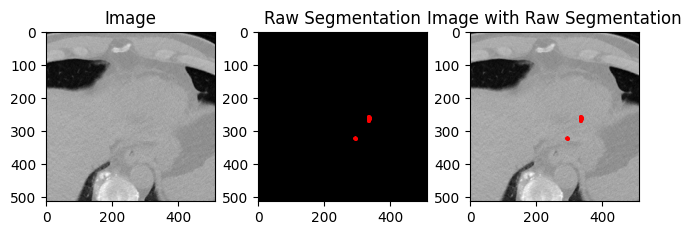

In [7]:
fig,ax=plt.subplots(1,3)
ax[0].set_title("Image")
ax[0].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[1].set_title("Raw Segmentation")
ax[1].imshow(np.ones([512,512]),cmap="gray")
ax[1].scatter(raw_plot_roi_list[:,0],raw_plot_roi_list[:,1],color="r",marker='o', s=(72./fig.dpi)**2)
ax[2].set_title("Image with Raw Segmentation")
ax[2].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[2].scatter(raw_plot_roi_list[:,0],raw_plot_roi_list[:,1],color="r",marker='o', s=(72./fig.dpi)**2)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

#### Data Cleaning

Convert floating point pixel location to integer location
Remove patient data with the following criteria:
- roi pixel overlapping
- mislabelled roi
- patient with multiple image id and roi
- invalid dicom
- no image


In [8]:
clean_json_path = list(project_root_path.rglob("clean*.json"))[0]
with clean_json_path.open(mode="r") as json_file:
    clean_dict_output = json.load(json_file)

In [9]:
# Amount of patient with segmentation after data cleaning
total_patient_seg_clean=len(clean_dict_output.keys())
total_patient_seg_clean

417

In [10]:
seg_percent_reduced = (total_patient_seg_raw - total_patient_seg_clean)/total_patient_seg_raw *100 
print(f"Percent reduced from patient with segmentation: {seg_percent_reduced}%")

Percent reduced from patient with segmentation: 7.5388026607538805%


#### Split Segment to Binary and Multiclass Segmentation

##### Binary

In [11]:
bin_seg_json_path = list(project_root_path.rglob("binary*.json"))[0]
with bin_seg_json_path.open(mode="r") as json_file:
    bin_seg_dict_output = json.load(json_file)

In [12]:
sample_patient_bin_seg_dict = bin_seg_dict_output[str(sample_patient_index).zfill(3)]
sample_image_with_bin_roi = sample_patient_bin_seg_dict[sample_patient_image_index]
sample_bin_roi = np.array(sample_image_with_bin_roi["pos"])

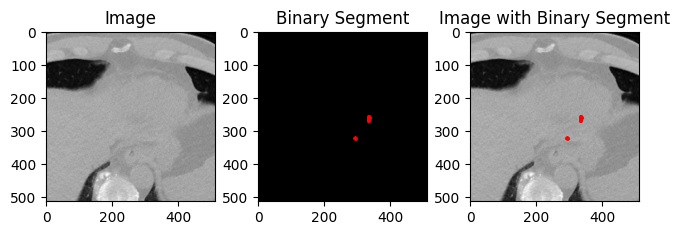

In [13]:
fig,ax=plt.subplots(1,3)
ax[0].set_title("Image")
ax[0].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[1].set_title("Binary Segment")
ax[1].imshow(np.ones([512,512]),cmap="gray")
ax[1].scatter(sample_bin_roi[:,0],sample_bin_roi[:,1],color="r",marker='o', s=(72./fig.dpi)**2)
ax[2].set_title("Image with Binary Segment")
ax[2].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[2].scatter(sample_bin_roi[:,0],sample_bin_roi[:,1],color="r",marker='o', s=(72./fig.dpi)**2)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

##### Multiclass

In [14]:
mult_seg_json_path = list(project_root_path.rglob("multi*.json"))[0]
with mult_seg_json_path.open(mode="r") as json_file:
    mult_seg_dict_output = json.load(json_file)

In [15]:
sample_patient_mult_seg_dict = mult_seg_dict_output[str(sample_patient_index).zfill(3)]
sample_image_with_mult_roi = sample_patient_mult_seg_dict[sample_patient_image_index]
sample_mult_roi = sample_image_with_mult_roi["roi"]

In [16]:
plot_mult_dict = {}

for mult_roi in sample_mult_roi:
    vessel_loc = convert_num_to_abr(mult_roi['loc'])
    vessel_pos=plot_mult_dict.get(vessel_loc,[])
    vessel_pos.extend(mult_roi["pos"])
    plot_mult_dict[vessel_loc]= vessel_pos

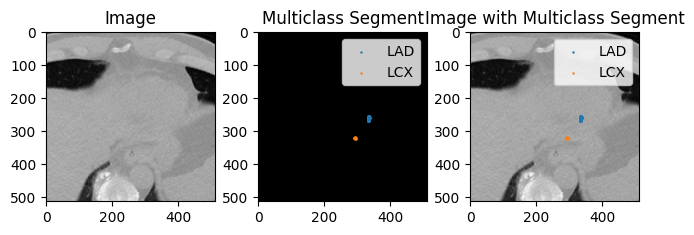

In [17]:
fig,ax=plt.subplots(1,3)
ax[0].set_title("Image")
ax[0].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[1].set_title("Multiclass Segment")
ax[1].imshow(np.ones([512,512]),cmap="gray")
for loc, p in plot_mult_dict.items():
    ax[1].scatter(np.array(p)[:,0],np.array(p)[:,1],marker='o', s=(72./fig.dpi)**2,label=loc)
ax[1].legend()
ax[2].set_title("Image with Multiclass Segment")
ax[2].imshow(sample_image_array,cmap="gray",interpolation='none')
for loc, p in plot_mult_dict.items():
    ax[2].scatter(np.array(p)[:,0],np.array(p)[:,1],marker='o', s=(72./fig.dpi)**2,label=loc)
ax[2].legend()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

#### Summary

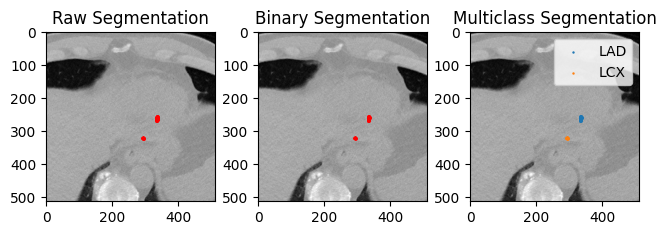

In [18]:
fig,ax=plt.subplots(1,3)
ax[0].set_title("Raw Segmentation")
ax[0].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[0].scatter(raw_plot_roi_list[:,0],raw_plot_roi_list[:,1],color="r",marker='o', s=(72./fig.dpi)**2)

ax[1].set_title("Binary Segmentation")
ax[1].imshow(sample_image_array,cmap="gray",interpolation='none')
ax[1].scatter(sample_bin_roi[:,0],sample_bin_roi[:,1],color="r",marker='o', s=(72./fig.dpi)**2)

ax[2].set_title("Multiclass Segmentation")
ax[2].imshow(sample_image_array,cmap="gray",interpolation='none')
for loc, p in plot_mult_dict.items():
    ax[2].scatter(np.array(p)[:,0],np.array(p)[:,1],marker='o', s=(72./fig.dpi)**2,label=loc)
ax[2].legend()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### Image

#### h5

In [19]:
index_h5_path = list(project_root_path.rglob("index.h5"))[0]

<KeysViewHDF5 ['000', '001', '002', '003', '005', '006', '007', '008', '009', '010', '011', '014', '015', '016']>
<KeysViewHDF5 ['img', 'pxl_spc', 'slc_thc']>
<KeysViewHDF5 ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057']>
<KeysViewHDF5 ['img_arr', 'img_hu']>
[[  86   84   78 ...   26   29   28]
 [  55   53   53 ...   29   29   24]
 [  38   35   34 ...   22   22   16]
 ...
 [1059 1070 1079 ...  860  839  807]
 [1043 1058 1074 ...  826  798  759]
 [1036 1051 1068 ...  780  746  705]]


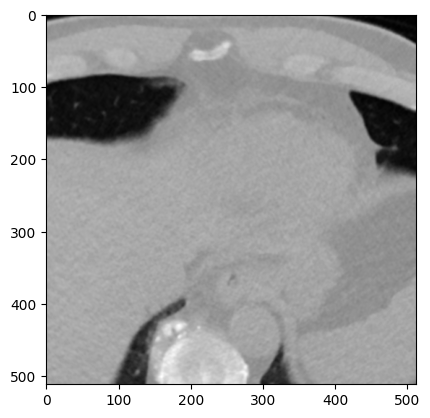

In [20]:
with h5py.File(index_h5_path,"r") as h5_index:
    print(h5_index.keys())
    print(h5_index[str(sample_patient_index).zfill(3)].keys())
    print(h5_index[str(sample_patient_index).zfill(3)]["img"].keys())
    print(h5_index[str(sample_patient_index).zfill(3)]["img"][str(sample_image_index).zfill(3)].keys())
    print(h5_index[str(sample_patient_index).zfill(3)]["img"][str(sample_image_index).zfill(3)]['img_arr'][:])
    plt.imshow(h5_index[str(sample_patient_index).zfill(3)]["img"][str(sample_image_index).zfill(3)]['img_arr'][:],cmap="gray")
    

#### Other Preprocessing method (TBD)

### TFRecord

#### Parsing TFRecord

In [21]:
tfrecord_path = list(project_root_path.rglob("*.tfrecord"))[0]
sample_tfrecord_data= tf.data.TFRecordDataset(tfrecord_path)

In [22]:
parsed_data = sample_tfrecord_data.map(parsed_example_fn)

In [23]:
for features in parsed_data.take(1):
    for key in features.keys():
        print(f"{key}: {features[key]}")

bin_seg: [[-1 -1]]
mult_seg: [[-1 -1 -1]]
idx: b'001'
img: [[  18   14   19 ...   78   54   40]
 [  19   12   13 ...   80   46   29]
 [  35   14   13 ...   82   45   25]
 ...
 [1003 1003 1002 ...  837  849  873]
 [ 998  988  976 ...  854  858  880]
 [1001  980  964 ...  876  868  879]]
patient_num: b'000'
